# How to determine causality? A hotel booking demand study 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import dowhy
import warnings
warnings.filterwarnings('ignore')

### Data pre-processing

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Data Dictionary

|variable                       |class     |description |
|:------------------------------|:---------|:-----------|
|hotel                          |string    | Resort Hotel or City Hotel |
|is_canceled                    |binary    | Indicating whether the booking was canceled, 1 - yes, 0 - no |
|lead_time                      |double    | Number of days between the booking and arrival dates |
|arrival_date_year              |double    | Year of arrival date|
|arrival_date_month             |string    | Month of arrival date|
|arrival_date_week_number       |double    | Week number of year for arrival date|
|arrival_date_day_of_month      |double    | Day of arrival date|
|stays_in_weekend_nights        |double    | Number of weekend nights booked |
|stays_in_week_nights           |double    | Number of week nights booked|
|adults                         |double    | Number of adults|
|children                       |double    | Number of children|
|babies                         |double    | Number of babies |
|meal                           |string    | Type of meal booked in meal packages: <br> Undefined/SC – no meal package;<br>BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board |
|country                        |string    | Country of origin. Categories are represented |
|market_segment                 |string    | Market segment designation, “TA” - “Travel Agents”, “TO” - “Tour Operators” |
|distribution_channel           |string    | Booking distribution channel, “TA” - “Travel Agents”, “TO” - “Tour Operators” |
|is_repeated_guest              |binary    | Value indicating if the booking name was from a repeated guest 1 - yes, 0 - no |
|previous_cancellations         |double    | Number of previous bookings that were cancelled by the customer in the past |
|previous_bookings_not_canceled |double    | Number of previous bookings that were not cancelled by the customer in the past |
|reserved_room_type             |string    | Code of room type reserved |
|assigned_room_type             |string    | Code for the type of room assigned to the booking |
|booking_changes                |double    | Number of changes made to the booking from the moment the booking was entered into the system until the moment of check-in/cancellation |
|deposit_type                   |string    | Indication on if the customer made a deposit to guarantee the booking. <br>No Deposit – no deposit was made;<br>Non Refund – a deposit was made in the value of the total stay cost;<br>Refundable – a deposit was made with a value under the total cost of stay |
|agent                          |double    | ID of the travel agency that made the booking |
|company                        |double    | ID of the company that made the booking or responsible for paying the booking |
|days_in_waiting_list           |double    | Number of days the booking was in the waiting list before it was confirmed |
|customer_type                  |string    | Type of booking, <br>Contract - when the booking has an allotment or other type of contract associated to it;<br>Group – when the booking is associated to a group;<br>Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>Transient party – when the booking is transient, but is associated to at least other transient booking|
|adr                            |double    | Average Daily Rate as defined by dividing the sum of lodging transactions by the number of staying nights |
|required_car_parking_spaces    |double    | Number of car parking spaces required by the customer |
|total_of_special_requests      |double    | Number of special requests made by the customer (twin bed or high floor ext..)|
|reservation_status             |string    | Reservation last status<br>Canceled – booking was canceled by the customer;<br>Check-Out – customer has checked in but already departed;<br>No-Show – customer did not check-in and did inform the hotel of the reason why |
|reservation_status_date        |double    | Date at which the last status was set |

#### Clean null values

In [3]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
# Replacing children's null values by 0
data['children']= data['children'].fillna(0)

# Replacing missing countries with most freqently occuring countries
data['country']= data['country'].fillna('PRT')

# We will drop 'agent' and 'company' since we have no use in them
data = data.drop(['agent', 'company'], axis=1)

data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

#### Merge and remove unnecessary columns/values

In [5]:
# total number of guests instead of the adults/children/babies separation
data['num_guests'] = (data['adults'] + data['children'] + data['babies'])
data = data.astype({'num_guests': int})

# total stay instead of the week night and weekend separation
data['total_stay'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']

# binary variable 'has_room_changed" instead of reserved room type and assigned room type
data['has_room_changed'] = 0
slice_indices = data['reserved_room_type'] != data['assigned_room_type']
data.loc[slice_indices,'has_room_changed'] = 1

# merge refundable deposit and non refundable deposit into one value
data.loc[data['deposit_type'] != 'No Deposit','deposit_type'] = 'Deposit'

# Deleting unnecessary attributes
data = data.drop(['adults', 'children', 'babies', 'stays_in_week_nights', 'stays_in_weekend_nights',
                  'reserved_room_type', 'assigned_room_type', 'reservation_status_date',
                  'market_segment', 'distribution_channel'], axis=1)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
booking_changes,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0
days_in_waiting_list,119390.0,2.321149,17.594721,0.00,0.00,0.000,0.0,391.0


#### Outlier detection

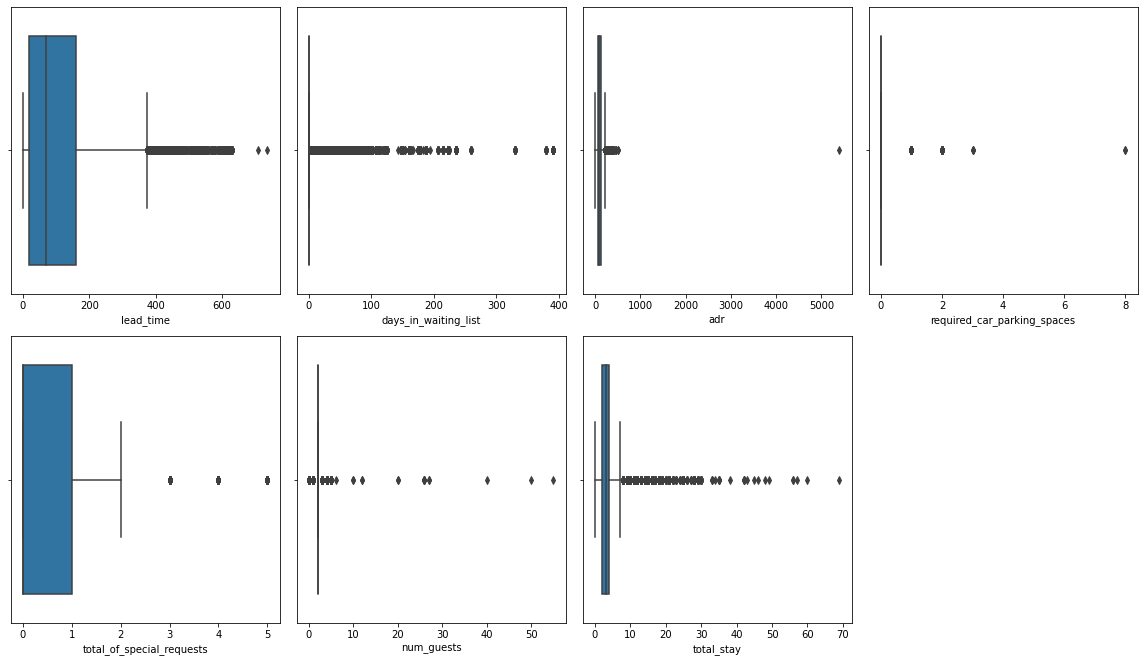

In [6]:

features = ['lead_time', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
            'total_of_special_requests', 'num_guests', 'total_stay']
n = 1
plt.figure(figsize=(16,18))
for feature in features:
    plt.subplot(4, 4, n)
    sns.boxplot(data[feature])
    n += 1
    plt.tight_layout()

#### Impute outliers

In [7]:

data.loc[data.lead_time                   >  600, 'lead_time'                 ] = 600
data.loc[data.days_in_waiting_list        >  125, 'days_in_waiting_list'      ] = 125
data.loc[data.adr                         >= 400, 'adr'                       ] = 400
data.loc[data.num_guests                  >  6,  'num_guests'                 ] = 6
data.loc[data.required_car_parking_spaces >  4,  'required_car_parking_spaces'] = 4
data.loc[data.total_of_special_requests   >  3,  'total_of_special_requests'  ] = 3

### Exploratory data analysis

#### How many booking were canceled from all bookings?

<AxesSubplot:ylabel='is_canceled'>

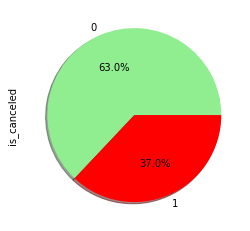

In [8]:
data['is_canceled'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, colors=['lightgreen', 'red'])

##### Most booking were not canceled, with only 37% of all bookings canceled.

#### What is the cancellation rate for repeated guests vs non repeated guests?

In [9]:
cancellation_rate = data.groupby(["is_repeated_guest", "is_canceled"]).size().reset_index(name='rate')
s = cancellation_rate.groupby("is_repeated_guest")['rate'].transform("sum")
cancellation_rate['rate'] = cancellation_rate['rate'].div(s)
cancellation_rate

,is_repeated_guest,is_canceled,rate
0,0,0,0.622149
1,0,1,0.377851
2,1,0,0.855118
3,1,1,0.144882


##### Repeated guests are less likely to cancel bookings, with a difference of 0.23%

#### What effect does a deposit have?

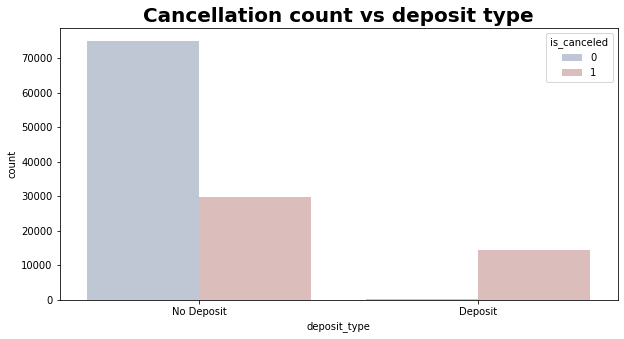

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x='deposit_type', hue="is_canceled", data=data,palette='vlag')
plt.title("Cancellation count vs deposit type", fontweight="bold", size=20)
plt.show()

##### As expected, if someone puts down a deposit, said person would most likely not cancel the booking. Still a question remains, does not putting down a deposit have a causal relationship between booking cancellation? meaning, that if someone does not put down a deposit, does this action make him more likely to cancel the booking?

#### What is the affect of lead time on cancellation rate?

<AxesSubplot:xlabel='is_canceled', ylabel='lead_time'>

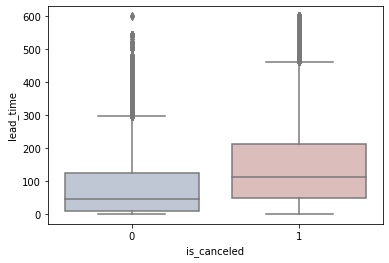

In [11]:
sns.boxplot(x='is_canceled', y='lead_time',data=data, palette='vlag')

##### Canceled bookings had higher lead time than non-canceled bookings

##### How does the amount of special requests affect the cancellation rate?

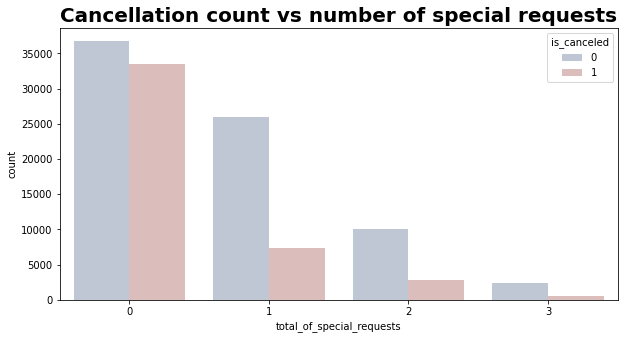

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(x='total_of_special_requests', hue="is_canceled", data=data, palette='vlag')
plt.title("Cancellation count vs number of special requests", fontweight="bold", size=20)
plt.show()

In [13]:
cancellation_rate = data.groupby(["total_of_special_requests", "is_canceled"]).size().reset_index(name='rate')
s = cancellation_rate.groupby("total_of_special_requests")['rate'].transform("sum")
cancellation_rate['rate'] = cancellation_rate['rate'].div(s)
print(cancellation_rate)

   total_of_special_requests  is_canceled      rate
0                          0            0  0.522796
1                          0            1  0.477204
2                          1            0  0.779751
3                          1            1  0.220249
4                          2            0  0.779011
5                          2            1  0.220989
6                          3            0  0.831769
7                          3            1  0.168231


##### The more special requests a customer has, the less likely he is to cancel the booking

### Correlation analysis

In [14]:
# In order to show the correlations, we first categorize the features with data type "object"
corr_data = data.copy()
for col in corr_data.dtypes.to_dict():
    if corr_data.dtypes.to_dict()[col] == "object":
        corr_data[col] = corr_data[col].astype('category').cat.codes

#### Correlation using the Pearson coefficient

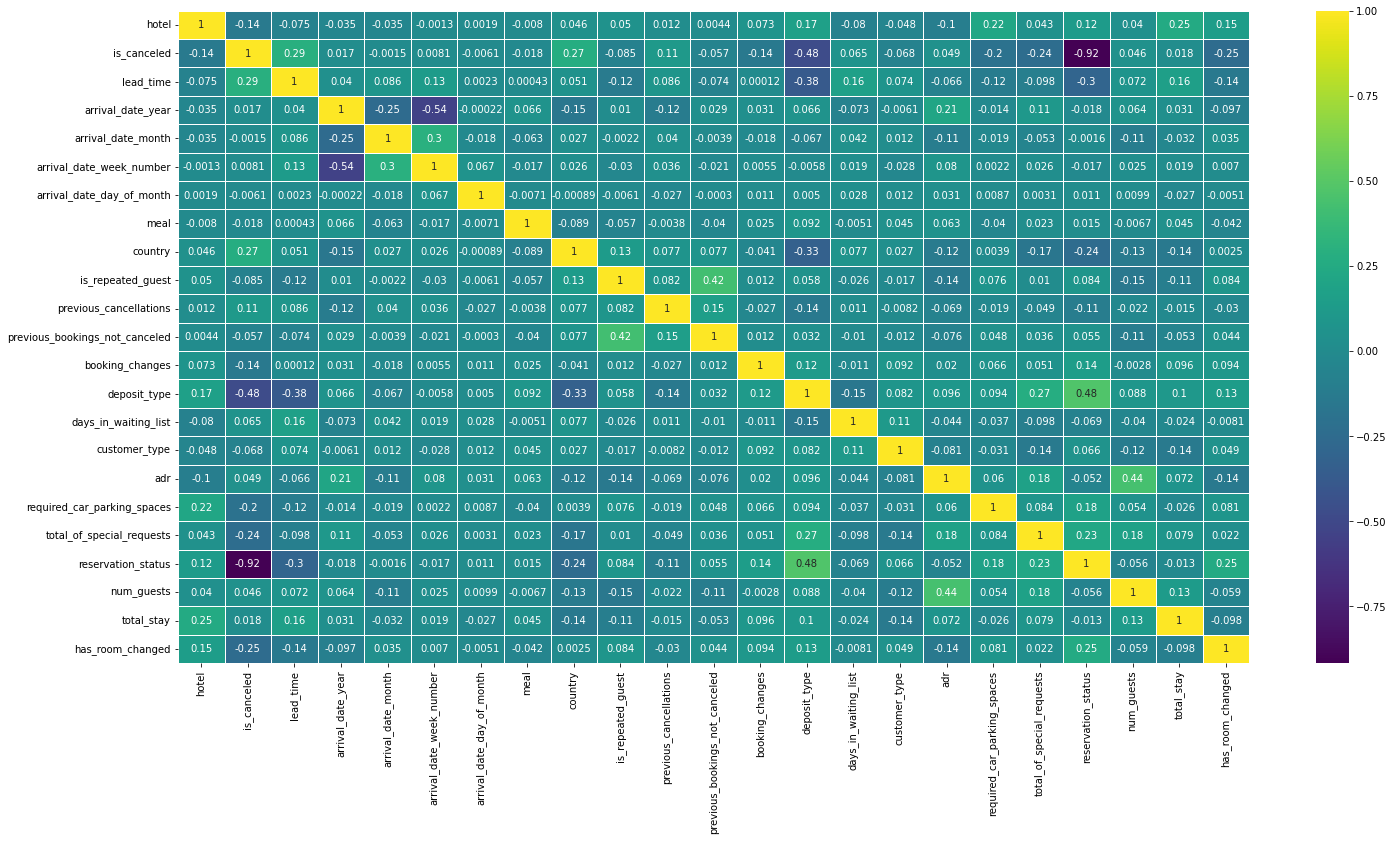

In [15]:
plt.figure(figsize = (24, 12))
sns.heatmap(corr_data.corr(method='pearson'), annot = True, linewidths = 1, cmap='viridis')
plt.show()

#### Correlation using the Spearman coefficient

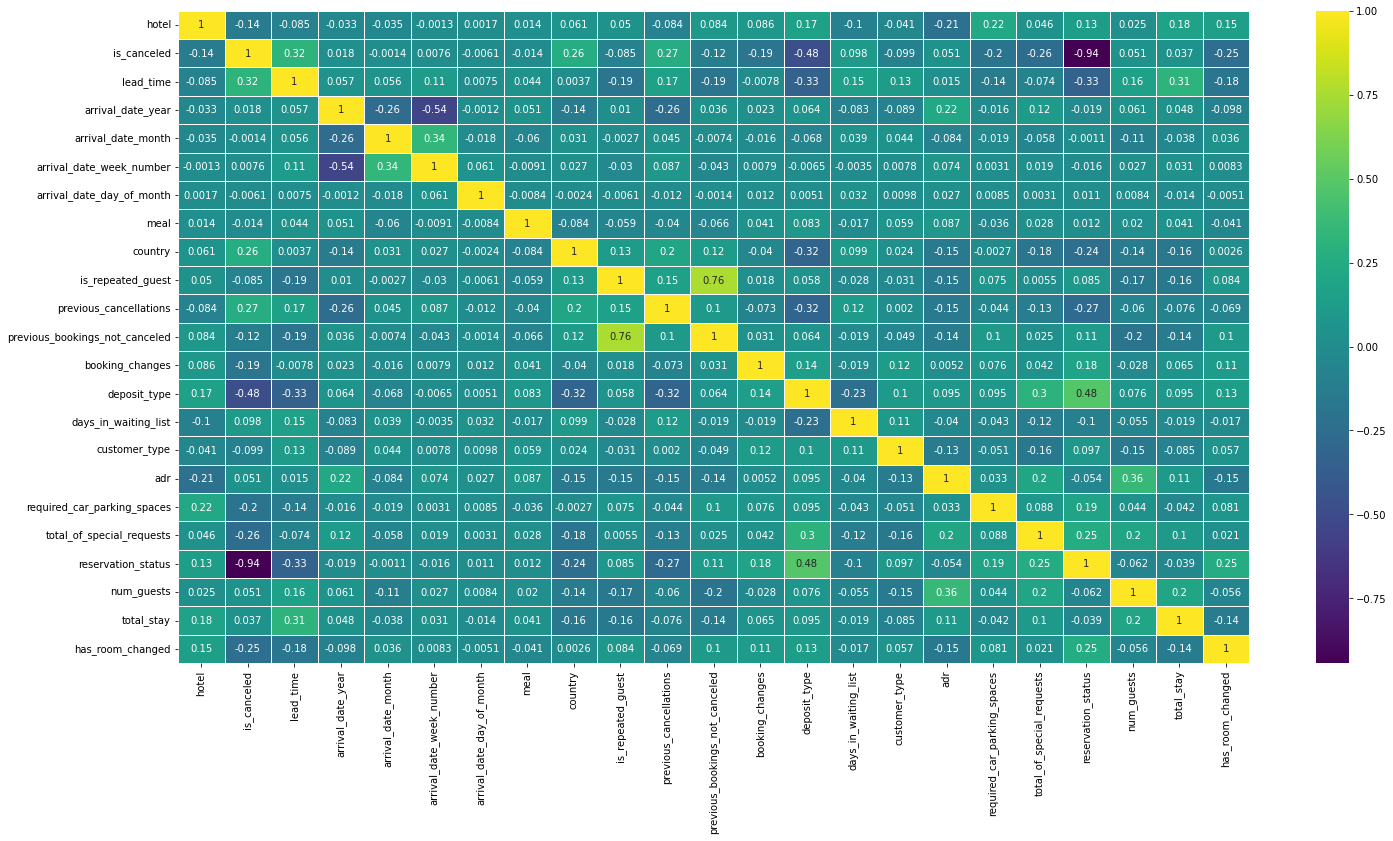

In [16]:
plt.figure(figsize = (24, 12))
sns.heatmap(corr_data.corr(method='spearman'), annot = True, linewidths = 1, cmap='viridis')
plt.show()

##### The difference between the two correlation coefficients is that the Pearson coefficient works with a linear relationship between the variables whereas the Spearman Coefficient works with monotonic relationships as well. A monotonic relationship meaning that as the value of one variable increases, so does the value of the other variable, or that as the value of one variable increases, the other variable value decreases. But not in a linear fashion. </br> Since we don't know that our data contains only linear relationships, we will use the Spearman coefficient for the analysis.

<AxesSubplot:>

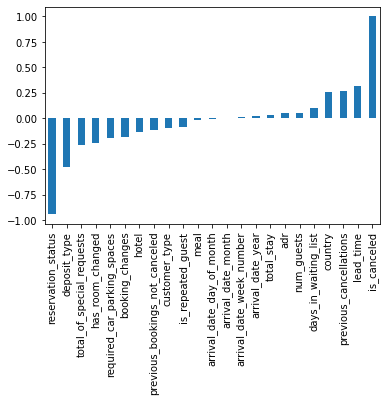

In [17]:
corr_data.corr(method='spearman')['is_canceled'].sort_values().plot(kind='bar')

##### Leaving out obvious correlations (reservation status), we can see that highly correlated variables to is_canceled are: 
1. lead time
2. deposit type
3. previous cancellations
4. country
5. special requests
6. booking or room changes
7. parking spaces

### Causal inference

#### In this section, we will try to understand the reasoning behind a booking cancellation. There are many reason why a booking may be canceled, maybe the customer requested for something that wasn't available? maybe the ADR was too high? maybe the customer did not get the room he/she ordered? The best procedure to finding causal relationships is via randomized controlled trails, where we have a control group and testing group, but most of the time, this option is either too expensive or highly unethical. What we will try to achieve in the following secion is to try and find causal relationships between variables using only collected data. 

In [18]:
# Convert intended attributes to binary attributes
data_encoded = data.copy()
data_encoded['deposit_type']= data_encoded['deposit_type'].replace('Deposit',True)
data_encoded['deposit_type']= data_encoded['deposit_type'].replace('No Deposit',False)
data_encoded['is_canceled']= data_encoded['is_canceled'].replace(1,True)
data_encoded['is_canceled']= data_encoded['is_canceled'].replace(0,False)
data_encoded.dropna(inplace=True)

#### 1. Create a causal graph with our prior knowledge of the data and assumptions

In [19]:
causal_graph = """digraph {
previous_cancellations[label="Previous Cancellations"];
deposit_type[label="Deposit"];
has_room_changed[label="Room Changed"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
days_in_waiting_list[label="Days in Waiting List"];
lead_time[label="Lead Time"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest[label="Is Repeated Guest"];
total_stay[label="Total Stay In Days"];
num_guests[label="Number of Guests"];
meal[label="Type of Meal"];
hotel[label="Type of Hotel"];
U -> {booking_changes, required_car_parking_spaces, total_stay, total_of_special_requests, previous_cancellations, num_guests};
previous_cancellations -> {is_canceled, total_of_special_requests, is_repeated_guest}
deposit_type -> {is_canceled, previous_cancellations};
lead_time -> {is_canceled, days_in_waiting_list}; 
country -> {num_guests, lead_time, meal, deposit_type};
days_in_waiting_list -> has_room_changed;
has_room_changed -> booking_changes;
is_repeated_guest -> {is_canceled};
booking_changes -> is_canceled;
hotel -> {has_room_changed, is_canceled, deposit_type};
num_guests -> {required_car_parking_spaces, total_stay, lead_time, total_of_special_requests, days_in_waiting_list, deposit_type};
required_car_parking_spaces -> {is_canceled, previous_cancellations};
total_of_special_requests -> {booking_changes, is_canceled};
}"""

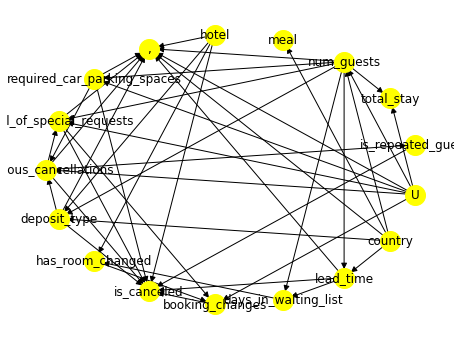

In [20]:
model = dowhy.CausalModel(
        data = data_encoded,
        graph=causal_graph.replace("\n", " "),
        treatment='deposit_type',
        outcome='is_canceled')
model.view_model()

#### What assumptions did we use? 
add here

#### 2. Detect the causal effects

In [21]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                
───────────────(E[is_canceled|hotel,num_guests,country])
d[deposit_type]                                         
Estimand assumption 1, Unconfoundedness: If U→{deposit_type} and U→is_canceled then P(is_canceled|deposit_type,hotel,num_guests,country,U) = P(is_canceled|deposit_type,hotel,num_guests,country)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### 3. Estimate the identified estimand

In [22]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting", 
                                 target_units="ate")
print(estimate)

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                
───────────────(E[is_canceled|hotel,num_guests,country])
d[deposit_type]                                         
Estimand assumption 1, Unconfoundedness: If U→{deposit_type} and U→is_canceled then P(is_canceled|deposit_type,hotel,num_guests,country,U) = P(is_canceled|deposit_type,hotel,num_guests,country)

## Realized estimand
b: is_canceled~deposit_type+hotel+num_guests+country
Target units: ate

## Estimate
Mean value: 0.6405053603931947



#### 4. Refute results

In [23]:
# Random Common Cause 
refute = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refute)

Refute: Add a random common cause
Estimated effect:0.6405053603931947
New effect:0.6404877221473214
p value:0.33999999999999997



In [24]:
# Data Subset Refuter 
refute = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute)

Refute: Use a subset of data
Estimated effect:0.6405053603931947
New effect:0.6402918108721327
p value:0.39



In [25]:
# Placebo Treatment Refuter
refute = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute)

Refute: Use a Placebo Treatment
Estimated effect:0.6405053603931947
New effect:-0.00016372506493188388
p value:0.47

